# Binary Classification with a Bank Churn Dataset
## Playground Series - Season 4, Episode 1

In [26]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost
from datetime import datetime as dt

# STATISTICS
from statsmodels.graphics.gofplots import qqplot

#notebook settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

#sklearn libraries

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, Binarizer, LabelEncoder, OneHotEncoder, TargetEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
# metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc, accuracy_score
# imbalanced datasets
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import TomekLinks,RandomUnderSampler
# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel
# model selection
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold
# pipelines
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.utils import class_weight

## READING FILES

**Bank Customer Churn Dataset**

The Bank Customer Churn Dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be customers. The dataset includes the following attributes:
- Customer ID: A unique identifier for each customer.
- Surname: The customer's surname or last name.
- Credit Score: A numerical value representing the customer's credit score.
- Geography: The country where the customer resides (France, Spain, or Germany).
- Gender: The customer's gender (Male or Female).
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank.
- Balance: The customer's account balance.
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card).
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no).
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no).
- EstimatedSalary: The estimated salary of the customer.
- Exited: Whether the customer has churned (1 = yes, 0 = no).

In [27]:
train_df = pd.read_csv('data/train.csv', index_col='id')
test_df = pd.read_csv('data/test.csv',index_col='id')
submission = pd.read_csv('data/sample_submission.csv')

## 1) EDA - Exploratory Data Analysis

### 1.1) Checking for missing values

In [28]:
train_df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [29]:
train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [30]:
test_df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [31]:
test_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


No missing Values in train and test data 😃✅

### 1.2) Checking for duplicated values

In [32]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


No duplicated Values in train and test data 😃✅

### 1.3) Size of train and test data

In [33]:
print(train_df.shape)
print(test_df.shape)

(165034, 13)
(110023, 12)


### 1.4) Uniques values

In [34]:
# let's start looking at the training data
train_df.nunique()

CustomerId         23221
Surname             2797
CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

### 1.5) data type information

In [35]:
train_df.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

- **Customer ID**:
  - Treatment: Exclude from modeling or use it as an index, but do not include it as a feature in your predictive model.
  - Why: Customer ID is usually a unique identifier and does not contribute to the model's predictive power. Including it may lead to overfitting, as the
  model might mistakenly learn patterns specific to individual customers that do not generalize well.

- **Surname**:
  - Treatment: Exclude from modeling.
  - Why: Surnames are categorical data, but including them in a model might not provide meaningful information. If you attempt to one-hot encode surnames, it could lead to an extremely high-dimensional dataset, making the model computationally expensive and potentially overfit to the training data.

## 2) PreProcess Data

In [36]:
# build a transform function to drop columns with scikit-learn BaseEstimator and TransformerMixin.
# It will receive a list of columns to drop and return the transformed dataframe without those columns.

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # copy the dataframe to avoid changes on the original input
        data = X.copy()
        # return the dataframe without the dropped columns
        return data.drop(labels=self.columns, axis='columns')

# let's test the DropColumns transformer
columns_to_drop = ['CustomerId', 'Surname']
train_drop_df = DropColumns(columns=columns_to_drop).fit_transform(train_df)


cat_ohe_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'] # order does not matter
cat_ord_features = ['NumOfProducts'] # order matters
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

# let's build a pipeline for cat features
cat_ohe_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

cat_ord_pipeline = Pipeline(steps=[
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# let's build a pipeline for numerical features
num_pipeline = Pipeline(steps=[
    ('robust_scaler', RobustScaler())
])

# let's join the numerical and categorical pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat_ohe', cat_ohe_pipeline, cat_ohe_features),
    ('cat_ord', cat_ord_pipeline, cat_ord_features),
    ('num', num_pipeline, num_features)
])

pipeline = Pipeline(steps=[
    ('drop_columns', DropColumns(columns=columns_to_drop)),
    ('preprocessor', preprocessor),
])


# let's test the pipeline on the training data
X_train = pipeline.fit_transform(train_df)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# create a dataframe with the transformed data and feature names
X_transformed = pd.DataFrame(X_train, columns=feature_names)

# check dataframe head
X_transformed.head()

,cat_ohe__Geography_France,cat_ohe__Geography_Germany,cat_ohe__Geography_Spain,cat_ohe__Gender_Female,cat_ohe__Gender_Male,cat_ohe__HasCrCard_0.0,cat_ohe__HasCrCard_1.0,cat_ohe__IsActiveMember_0.0,cat_ohe__IsActiveMember_1.0,cat_ord__NumOfProducts,num__CreditScore,num__Age,num__Tenure,num__Balance,num__EstimatedSalary
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.079646,-0.4,-0.50,0.000000,0.788698
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,-0.283186,-0.4,-1.00,0.000000,-0.850085
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.168142,0.3,1.25,0.000000,0.831134
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.690265,-0.3,-0.75,1.241313,-0.414670
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.504425,-0.4,0.00,0.000000,-1.277766


In [37]:
# use xgboost as the model for our pipeline
model = xgboost.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False
)

# let's create a pipeline with our previous pipeline (preprocessor) and the model
clf = Pipeline(steps=[
    ('preprocessor', pipeline),
    ('classifier', model)
])

# let's check the cross validation score of our pipeline with stratified k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, train_df, train_df['Exited'], cv=cv, scoring='roc_auc')
print('ROC AUC scores for the 5 folds: ', scores)
print('Mean ROC AUC score: %.3f' % scores.mean())

# let's train our model
clf.fit(train_df, train_df['Exited'])

# let's make predictions on the test set
predictions = clf.predict_proba(test_df)[:, 1]

ROC AUC scores for the 5 folds:  [0.88859008 0.88762624 0.88949107 0.88851367 0.88396808]
Mean ROC AUC score: 0.888


In [38]:
def cross_validation(model, X, y, cv=cv, scoring='roc_auc'):
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    print(f'CV Mean {scoring}: ', cv_scores.mean())
    print(f'STD {scoring}: ', cv_scores.std())
    print(f'Max {scoring}: ', cv_scores.max())
    print(f'Min {scoring}: ', cv_scores.min())
    print(f'{scoring} values: ', cv_scores)

# let's create a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# let's create a function to plot the ROC curve
def plot_roc_curve(y_true, y_pred_proba, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc,)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',)
    plt.ylabel('True Positive Rate',)
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# let's create a function to plot the learning curve
def plot_learning_curve(model, X, y, cv=cv, scoring='roc_auc'):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.figure(figsize=(5, 5))
    plt.plot(train_sizes, train_scores_mean, label='Train score')
    plt.plot(train_sizes, test_scores_mean, label='Test score')
    plt.ylabel(scoring)
    plt.xlabel('Training set size')
    plt.title('Learning curve')
    plt.legend()
    plt.show()

In [51]:
#plot cross validation
cross_validation(clf, train_df, train_df['Exited'])

CV Mean roc_auc:  0.8876378292260801
STD roc_auc:  0.0019274646772651203
Max roc_auc:  0.8894910744874158
Min roc_auc:  0.883968078534834
roc_auc values:  [0.88859008 0.88762624 0.88949107 0.88851367 0.88396808]


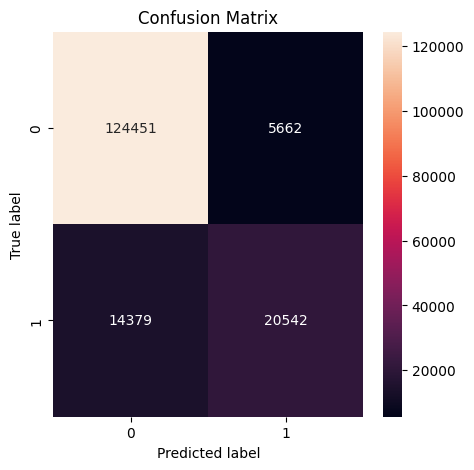

In [52]:
#plot confusion matrix
plot_confusion_matrix(train_df['Exited'], clf.predict(train_df))

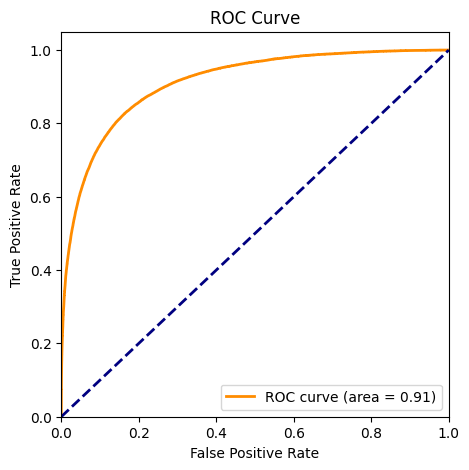

In [53]:
#plot roc curve
plot_roc_curve(train_df['Exited'], clf.predict_proba(train_df)[:, 1])

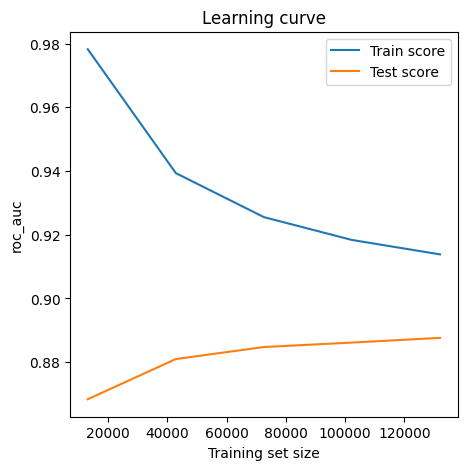

In [54]:
#plot learning curve
plot_learning_curve(clf, train_df, train_df['Exited'])

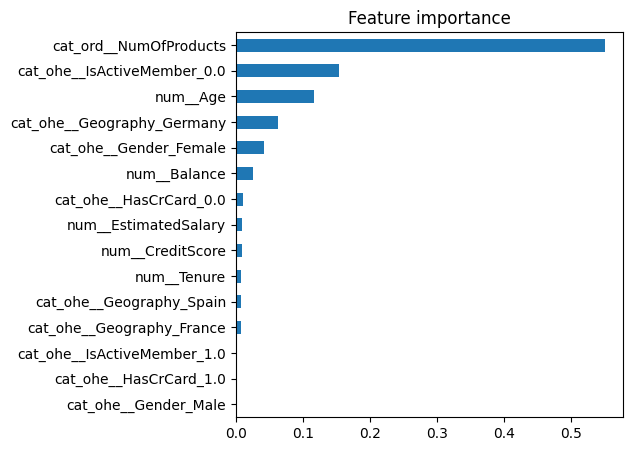

In [58]:
# let's create a function to plot the feature importance
def plot_feature_importance(model, X, y):
    plt.figure(figsize=(5, 5))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh')
    plt.title('Feature importance')
    plt.show()

plot_feature_importance(clf.named_steps['classifier'], X_transformed, train_df['Exited'])

In [59]:
# we should try to improve our model by tuning the hyperparameters
# let's create a function to do that
def hyperparameter_tuning(model, X, y, param_grid, cv=cv, scoring='roc_auc', search_type='GridSearchCV'):
    if search_type == 'GridSearchCV':
        search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    elif search_type == 'RandomizedSearchCV':
        search = RandomizedSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    search.fit(X, y)
    print(f'Best parameters: {search.best_params_}')
    print(f'Best {scoring}: {search.best_score_}')
    return search.best_params_

param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [3, 5, 7, 9, 11],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'classifier__gamma': [0, 0.25, 0.5, 1.0],
    'classifier__reg_lambda': [0, 1.0, 10.0],
    'classifier__scale_pos_weight': [1, 3, 5]
}

hyperparameter_tuning(clf, train_df, train_df['Exited'], param_grid, search_type='RandomizedSearchCV')

/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/pyt

Best parameters: {'classifier__scale_pos_weight': 5, 'classifier__reg_lambda': 1.0, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0}
Best roc_auc: 0.8894155488728778


{'classifier__scale_pos_weight': 5,
 'classifier__reg_lambda': 1.0,
 'classifier__n_estimators': 200,
 'classifier__max_depth': 5,
 'classifier__learning_rate': 0.05,
 'classifier__gamma': 0}

In [60]:
# best parameters
param_grid = {
    'classifier__scale_pos_weight': 5,
    'classifier__reg_lambda': 1.0,
    'classifier__n_estimators': 200,
    'classifier__max_depth': 5,
    'classifier__learning_rate': 0.05,
    'classifier__gamma': 0}

# let's train our model with the best parameters
clf.set_params(**param_grid)
clf.fit(train_df, train_df['Exited'])

# let's make predictions on the test set
predictions_optimized = clf.predict_proba(test_df)[:, 1]

In [61]:
# cross validation
cross_validation(clf, train_df, train_df['Exited'])

CV Mean roc_auc:  0.8894155488728778
STD roc_auc:  0.0013403284559979323
Max roc_auc:  0.8907158619761583
Min roc_auc:  0.8869664198581464
roc_auc values:  [0.88972015 0.88918795 0.89048736 0.89071586 0.88696642]


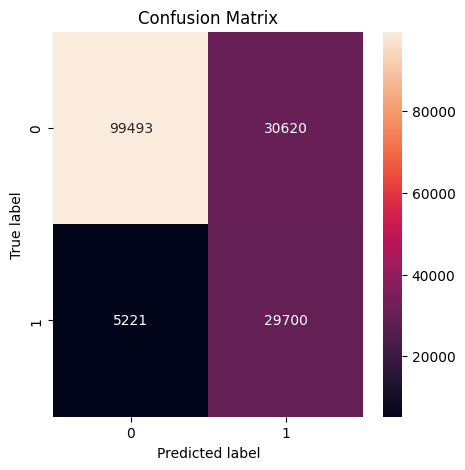

In [62]:
# confusion matrix
plot_confusion_matrix(train_df['Exited'], clf.predict(train_df))

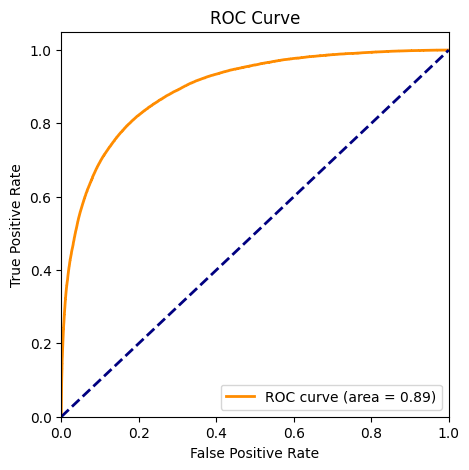

In [63]:
#plot roc curve
plot_roc_curve(train_df['Exited'], clf.predict_proba(train_df)[:, 1])

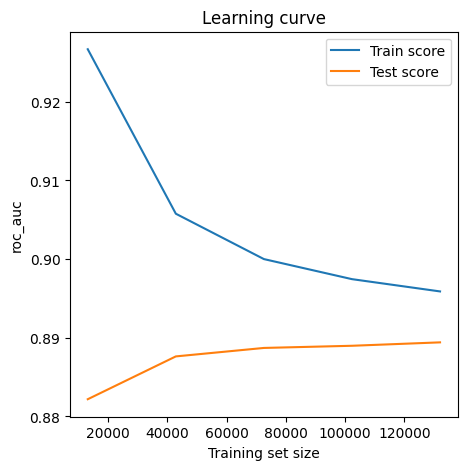

In [64]:
#plot learning curve
plot_learning_curve(clf, train_df, train_df['Exited'])

## 3) Submission

In [60]:
# second submission
test = test_df.copy()

# predict
y_pred = clf.predict_proba(test)[:, 1]

# add to submission dataframe
submission['Exited'] = y_pred

# save to csv
submission.to_csv('data/submission_2.csv', index=False)

# second value for my model was: 0.88458

In [65]:
# third submission
test = test_df.copy()

# predict
y_pred = clf.predict_proba(test)[:, 1]

# add to submission dataframe
submission['Exited'] = y_pred

# save to csv
submission.to_csv('data/submission_3.csv', index=False)